In [1]:
%pylab inline

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

df = pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv', index_col=0)

# downsample negative cases -- there are many more negatives than positives
indices = np.where(df.default == 'No')[0]
rng = np.random.RandomState(13)
rng.shuffle(indices)
n_pos = (df.default == 'Yes').sum()
df = df.drop(df.index[indices[n_pos:]])

df.head()                 

Populating the interactive namespace from numpy and matplotlib


,default,student,balance,income
20,No,No,1095.072735,26464.631389
38,No,No,351.453472,35087.488648
61,No,No,766.234379,46478.294257
78,No,No,728.373251,45131.718265
79,No,No,76.991291,28392.093412


/Users/paulsingman/pyth/data-analysis/venv/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


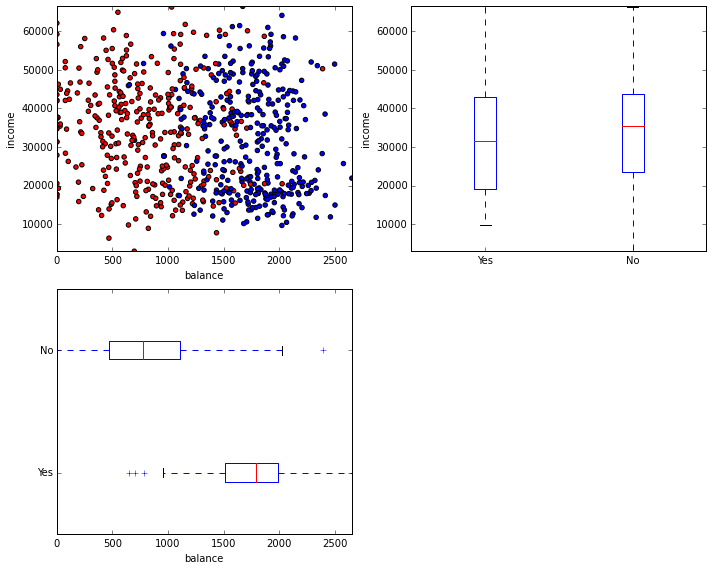

In [2]:
from matplotlib.colors import ListedColormap

# setup figure
plt.figure(figsize=(10, 8))

# scatter plot of balance (x) and income (y)
ax1 = plt.subplot(221)
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax1.scatter(df.balance, df.income, c=(df.default == 'Yes'), cmap=cm_bright)
ax1.set_xlim((df.balance.min(), df.balance.max()))
ax1.set_ylim((df.income.min(), df.income.max()))
ax1.set_xlabel('balance')
ax1.set_ylabel('income')
ax1.legend(loc='upper right')

# box plots for income
ax2 = plt.subplot(222)
ax2.boxplot([df.income[df.default == 'Yes'], df.income[df.default == 'No']])
ax2.set_ylim((df.income.min(), df.income.max()))
ax2.set_xticklabels(('Yes', 'No'))
ax2.set_ylabel('income')

# box plots for balance
ax3 = plt.subplot(223)
ax3.boxplot([df.balance[df.default == 'Yes'], df.balance[df.default == 'No']], vert=0)
ax3.set_xlim((df.balance.min(), df.balance.max()))
ax3.set_yticklabels(('Yes', 'No'))
ax3.set_xlabel('balance')
plt.tight_layout()

In [3]:
## Appendix with utility functions

from matplotlib.colors import ListedColormap

# utility function to plot the decision surface
def plot_surface(est, x_1, x_2, ax=None, threshold=0.0, contourf=False):
    """Plots the decision surface of ``est`` on features ``x1`` and ``x2``. """
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))
    # plot the hyperplane by evaluating the parameters on the grid
    X_pred = np.c_[xx1.ravel(), xx2.ravel()]  # convert 2d grid into seq of points
    if hasattr(est, 'predict_proba'):  # check if ``est`` supports probabilities
        # take probability of positive class
        pred = est.predict_proba(X_pred)[:, 1]
    else:
        pred = est.predict(X_pred)
    Z = pred.reshape((100, 100))  # reshape seq to grid
    if ax is None:
        ax = plt.gca()
    # plot line via contour plot

    if contourf:
        ax.contourf(xx1, xx2, Z, levels=np.linspace(0, 1.0, 10), cmap=plt.cm.RdBu, alpha=0.6)
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

def plot_datasets(est=None):
    """Plotsthe decision surface of ``est`` on each of the three datasets. """
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))
    for (name, ds), ax in zip(datasets.iteritems(), axes):
        X_train = ds['X_train']
        y_train = ds['y_train']
        X_test = ds['X_test']
        y_test = ds['y_test']

        # plot test lighter than training
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])
        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
        # plot limits
        ax.set_xlim(X_train[:, 0].min(), X_train[:, 0].max())
        ax.set_ylim(X_train[:, 1].min(), X_train[:, 1].max())
        # no ticks
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_ylabel('$x_1$')
        ax.set_xlabel('$x_0$')
        ax.set_title(name)
        if est is not None:
            est.fit(X_train, y_train)
            plot_surface(est, X_train[:, 0], X_train[:, 1], ax=ax, threshold=0.5, contourf=True)
            err = (y_test != est.predict(X_test)).mean()
            ax.text(0.88, 0.02, '%.2f' % err, transform=ax.transAxes)

    fig.subplots_adjust(left=.02, right=.98)

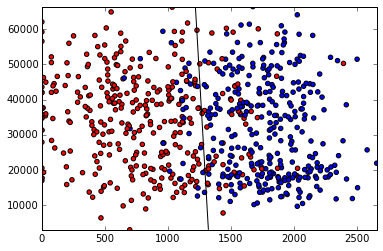

In [5]:
# A simple approach is to simply encode default as a numeric var with 
# 'Yes' == 1 and 'No' == 0. The points for which the regression
# model predicts 0.0 lie on the decision surface

from sklearn.linear_model import LinearRegression

# get feature/predictor matrix as numpy array
X = df[['balance', 'income']].values

# enocde class labels
classes, y = np.unique(df.default.values, return_inverse=True)
y = (y * 2) - 1 # map {0,1} to {-1, 1}

# fit OLS regression
est = LinearRegression(fit_intercept=True, normalize=True)
est.fit(X, y)

# plot data and decision surface
ax = plt.gca()
ax.scatter(df.balance, df.income, c=(df.default =='Yes'), cmap=cm_bright)
try:
    plot_surface(est, X[:, 0], X[:, 1], ax=ax)
except NameError:
    print('Please run cells in Appendix first')

In [7]:
# Points on left side of decision boundary are classified as negative
# Points ont he right side position. We can asses the performance
# of the model looking at the confusion matrix -- a cross tabulation of the actual
# and predicted class labels. The correct classifications are shown in the diagonal of
# of the confustion matrix. The off-diagonal terms show you the
# classification errors. Misclassification rate is simply
# Num errors/ Total Num of cases

from sklearn.metrics import confusion_matrix as sk_confusion_matrix

# the larger operator will return a boolean array which we will cast
# as intergers for fancy indexing

y_pred = (2 * (est.predict(X) > 0.0)) - 1

def confusion_matrix(y_test, y_pred):
    cm = sk_confusion_matrix(y, y_pred)
    cm = pd.DataFrame(data=cm, columns=[-1, 1], index=[-1, 1])
    cm.columns.name = 'Predicted label'
    cm.index.name = 'True label'
    error_rate = (y_pred != y).mean()
    print('error rate %.2f' % error_rate)
    return cm

confusion_matrix(y, y_pred)

error rate 0.12


Predicted label,-1,1
True label,,
-1,282,51
1,29,304


In [8]:
# In the above example we are assessing the model performance
# on the same data that we used to fit the model. This might be a 
# a biased estimate of the models performance, for a classifier
# that simple memorizes the training data has zero training error
# but would be totally useless to make predictions. It is much 
# better to assess the model performance ona  separate dataset called
# the test data or held-out data. Scikit-learn provides a number of ways
# to compute such held-out estimates of the model performance. One way
# is to simply split the data into a training and testing set.

from sklearn.cross_validation import train_test_split

# create 80%-20% train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# fit on training data
est = LinearRegression().fit(X_train, y_train)

#test on data that was not used for fitting
y_red = (2 * (est.predict(X) > 0.0)) - 1

confusion_matrix(y_test, y_pred)

error rate 0.12


Predicted label,-1,1
True label,,
-1,282,51
1,29,304


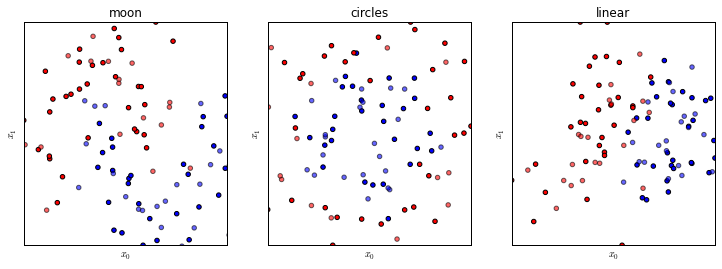

In [13]:
## DIfferent classification techniques can be compared using the type of 
# decision surface they can learn. The decision surfaces describe for what
# values of the predictors the model changes its predictions and it can take 
# several different shapes: piece-wise constant, linear, quadratic,
# vornio tessellation, ...

# This section will introduce three popular classification techniques:
# Logistic Regression, Discriminant Analysis, and Nearest Neighbor. We will 
# investigate what their strengths and weaknesses are by looking at the decision
# boundaries they can model. In the following we will use three synthetic
# datasets that we adopted from this scikit-learn example.

# Adopted from Gael Varoqueux & Andreas Mueller

from collections import OrderedDict
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification

# generate 3 synthetic datasets
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                         random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = OrderedDict()
for name, (X, y) in [('moon', make_moons(noise=0.3, random_state=0)),
                    ('circles', make_circles(noise=0.2, factor=0.5, random_state=1)),
                    ('linear', linearly_separable)]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)
    # Standardize data
    scaler = StandardScaler().fit(X_train)
    datasets[name] = {'X_train': scaler.transform(X_train), 'y_train': y_train,
                     'X_test': scaler.transform(X_test), 'y_test': y_test}
    
# plots the datasets - see Appendix
plot_datasets()

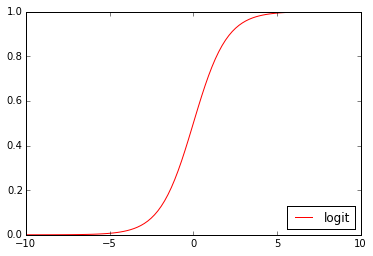

In [14]:
# Logistic Regression can be viewed as an extension of linear regression
# to classification problems. One of the limitations of linear regression is that
# it cannot provide class probability estimates. This is often useful, 
# for example, when we want to inspect manually the most fraudulent cases.
# Basically we would like to constrain the predictions of the model to range
# [0,1] so that we can interpret them as probability estimates. In 
# Logistic regression we use the logit function to clamp predictions.

x = np.linspace(-10, 10, 100)
y = 1.0 / (1.0 + np.exp(-x))

plt.plot(x, y, 'r-', label='logit')
plt.legend(loc='lower right')

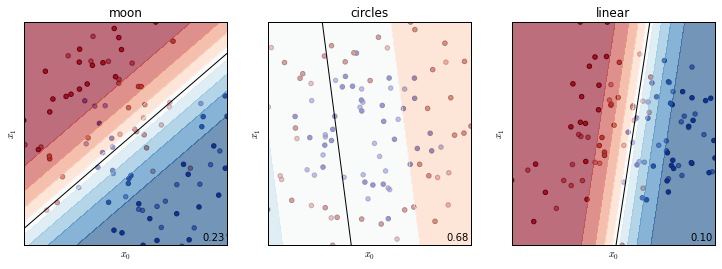

In [15]:
from sklearn.linear_model import LogisticRegression

est = LogisticRegression()
plot_datasets(est)

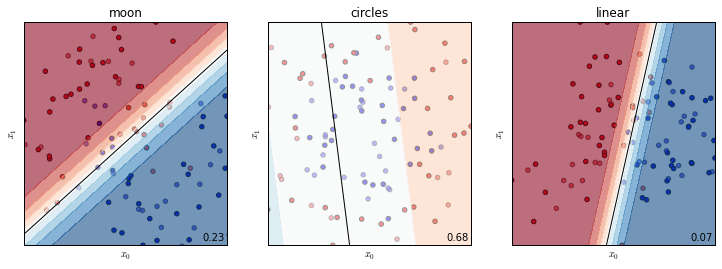

In [16]:
# As we can see, a linear decision boundary is not a poor approx for
# the moon datasets, although we failt to separate the two tips of the sickles in the cent
# center. It does poorly on circles and great on linear.
# More white means it is uncertain about its prediction.

# Linear discriminant Analysis

# Linear Discriminant analysis (LDA) is another popular technizue which shares
# some similarities with LogisticRegression. LDA too finds linear boundary
# between the two classes where points on side are classified as one class
# and those on the other ar classified as the other class.

from sklearn.lda import LDA

est = LDA()
plot_datasets(est)

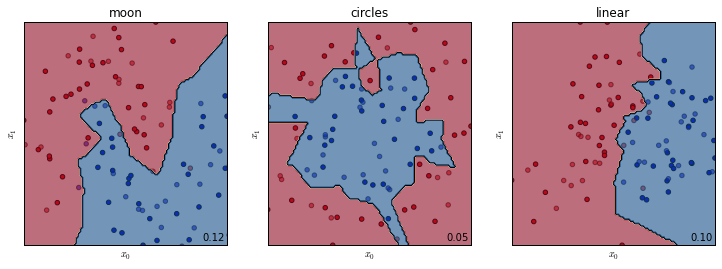

In [17]:
# The major difference between LDA dn LR is the way eadhc picks the linear
# decision boundary. LDA models the deciions boundary by making distributional
# assumptions about the data generating process while LR model the 
# probability of a sample being member of a class given its feature values.

## Nearest Neighbor

# Nearest Neighbor uses the notion of similarity to assign lass labels; it is based
# on the smoothness assumption that poinrs which are nearby in input space
# should have similar outputs. It does this by specifying a similarity
# (or distance) metric, and at prediction time it simply searches for the k most
# similar among the training examples to a given test example. The prediction
# is then either a majority vote of those k training example or a vote weighted
# by similarity. The parameter k specifies the smoothness of the decision
# surface. The decision durface of a k-nearest neighbor classifier can be illustrated by y
# by the Voronoi tesselation of the training data, that show you
# regions of constant responses. 

# NN is different from LDA or LR b/c it is a non-parametric techique;
# the number of parameters of the model can grow infinitely as the size of
# the training data grows. It can model non-linear decision boundaries, something
# that is important for the first two datasets moons and circles.

from sklearn.neighbors import KNeighborsClassifier

est = KNeighborsClassifier(n_neighbors=1)
plot_datasets(est)

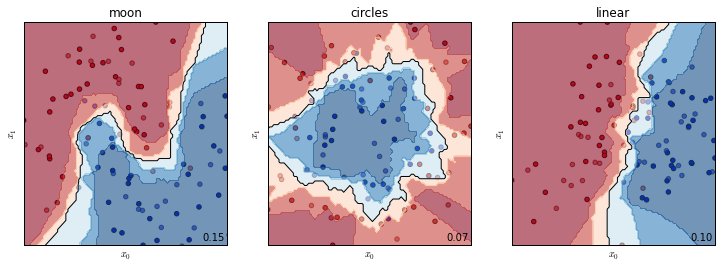

In [18]:
# try increasing k to enforce smoothness assumption.

est = KNeighborsClassifier(n_neighbors=5)
plot_datasets(est)

In [ ]:
# Finito